In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random

In [2]:
df = pd.read_csv("Airliner-v2.csv", delimiter=',', skiprows=0, low_memory=False)
df

,V,Prob,F,B,E,Space,Value
0,S1,0.15,25,60,210,2.0,1600.0
1,S2,0.30,12,30,170,1.5,1100.0
2,S3,0.30,5,9,150,1.0,500.0
3,S4,0.15,7,20,120,NaN,NaN
4,S5,0.10,20,18,160,NaN,NaN


In [3]:
Nspace=200
model = AbstractModel()
model.s = RangeSet(1,5)
model.clas = RangeSet(1,3)
model.x = Var(model.clas, initialize=0, bounds=(0,Nspace),domain=NonNegativeIntegers)
model.S = Var(model.s,model.clas, initialize=0, bounds=(0,Nspace),domain=NonNegativeIntegers)

model.E = Var( initialize=0, bounds=(0,1000000),domain=Reals)

model.pr =Param(model.s,mutable=True, initialize=1) 
model.V =Param(model.clas,mutable=True, initialize=1) 
model.coef =Param(model.clas,mutable=True, initialize=1) 
def rue_c1(model):
    return sum(model.coef[c]*model.x[c] for c in model.clas)<=Nspace
model.C1 =Constraint(rule=rue_c1)
def rue_c2(model,s,c):
    return model.S[s,c] <= df.iloc[s-1,c+1]
model.C2 =Constraint(model.s, model.clas,rule=rue_c2)
def rue_c2A(model,s,c):
    return model.S[s,c] <= model.x[c]
model.C2A =Constraint(model.s,model.clas,rule=rue_c2A)

def rue_c3A(model):
    return model.E==sum(model.pr[s]*model.V[c]*model.S[s,c] for s in model.s for c in model.clas)
model.C3A =Constraint(rule=rue_c3A)

model.obj = Objective(rule= model.E, sense=maximize)

In [4]:
instance = model.create_instance()

opt = SolverFactory('cbc')
results=opt.solve(instance)

from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))

this is feasible and optimal


1 12.0 12.0
2 28.0 28.0
3 160.0 160.0


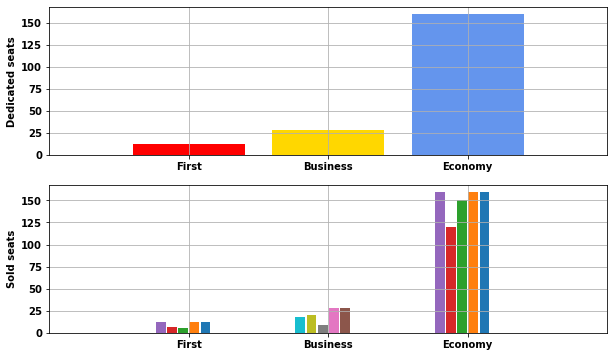

In [5]:
plt.figure(figsize=(10,6))

for c in instance.clas:
    print(c,value(instance.x[c]), value(instance.coef[c]*instance.x[c]))
    
plt.subplot(2,1,1)
    
Seats=[value(instance.x[c]) for c in instance.clas ]
cls=[c for c in instance.clas]
plt.bar(cls,Seats,  color=['red','gold','cornflowerblue'])
plt.xticks(cls, ['First' ,'Business' ,'Economy'], fontweight='bold')  
plt.yticks(fontweight='bold')  
plt.ylabel('Dedicated seats', fontweight='bold')
plt.xlim(0,4)
plt.grid()
plt.subplot(2,1,2)

for c in instance.clas:
    for s in instance.s:
        plt.bar(c+0.2-0.08*s,value(instance.S[s,c]), width=0.07)
    
plt.xticks(cls, ['First' ,'Business' ,'Economy'], fontweight='bold')  
plt.yticks(fontweight='bold')  

plt.ylabel('Sold seats', fontweight='bold')
plt.xlim(0,4)
plt.grid()